# DAY12 窗口函数

In [1]:
# install required libraries if necessary
# pip install matplotlib pandas ffn

import datetime
import random

import ffn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tushare as ts

%matplotlib inline

In [2]:
tickers = 'tsla,spot,nflx,nke,addyy'.split(',')

# get stock price data
prices = ffn.get(tickers, start="2022-01-01")

# convert data into 'long' table format for purposes of this exercise
prices = prices.melt(ignore_index=False, var_name="ticker", value_name="closing_price")

# reset index to make 'Date' a column
prices = prices.reset_index()

# display 5 example rows in the dataset
prices.sample(5).sort_index()


,Date,ticker,closing_price
99,2022-05-24,tsla,628.159973
133,2022-07-14,tsla,714.940002
316,2022-02-08,nflx,403.529999
409,2022-06-23,nflx,181.710007
702,2022-06-28,addyy,88.559998


In [3]:
import sqlite3

# create connection to in memory sqlite db
with sqlite3.connect(":memory:") as conn:

    # save prices dataframe to sqlite db
    prices.to_sql(name="prices", con=conn, index=False)


In [4]:
ex1_sql_query = """
SELECT
    date(Date) as Date
    , ticker
    , closing_price
    , MAX(closing_price) OVER(PARTITION BY ticker) as max_price
FROM
    prices
ORDER BY 2 DESC
"""


In [5]:
# use pandas read_sql to execute the query and return a dataframe
ex1_sql = pd.read_sql(ex1_sql_query, con=conn)
ex1_sql


,Date,ticker,closing_price,max_price
0,2021-12-31,tsla,1056.780029,1199.780029
1,2022-01-03,tsla,1199.780029,1199.780029
2,2022-01-04,tsla,1149.589966,1199.780029
3,2022-01-05,tsla,1088.119995,1199.780029
4,2022-01-06,tsla,1064.699951,1199.780029
...,...,...,...,...
720,2022-07-25,addyy,90.019997,144.263733
721,2022-07-26,addyy,83.650002,144.263733
722,2022-07-27,addyy,83.330002,144.263733
723,2022-07-28,addyy,85.300003,144.263733


In [6]:
# copy dataframe to avoid overwritting original (optional)
ex1_pandas = prices.copy()

# add new column
ex1_pandas["max_price"] = ex1_pandas.groupby("ticker")["closing_price"].transform("max")

ex1_pandas

,Date,ticker,closing_price,max_price
0,2021-12-31,tsla,1056.780029,1199.780029
1,2022-01-03,tsla,1199.780029,1199.780029
2,2022-01-04,tsla,1149.589966,1199.780029
3,2022-01-05,tsla,1088.119995,1199.780029
4,2022-01-06,tsla,1064.699951,1199.780029
...,...,...,...,...
720,2022-07-25,addyy,90.019997,144.263733
721,2022-07-26,addyy,83.650002,144.263733
722,2022-07-27,addyy,83.330002,144.263733
723,2022-07-28,addyy,85.300003,144.263733


In [7]:
ex2_sql_query = """
SELECT
    date(Date) AS Date
    , ticker
    , closing_price
    , AVG(closing_price) OVER(
        PARTITION BY ticker
        ORDER BY date(Date)
        ROWS 6 PRECEDING 
    )
     AS ma_7_day
FROM
    prices
ORDER BY 2 DESC
"""

In [8]:
ex2_sql = pd.read_sql(ex2_sql_query, con=conn)
ex2_sql

,Date,ticker,closing_price,ma_7_day
0,2021-12-31,tsla,1056.780029,1056.780029
1,2022-01-03,tsla,1199.780029,1128.280029
2,2022-01-04,tsla,1149.589966,1135.383341
3,2022-01-05,tsla,1088.119995,1123.567505
4,2022-01-06,tsla,1064.699951,1111.793994
...,...,...,...,...
720,2022-07-25,addyy,90.019997,87.419999
721,2022-07-26,addyy,83.650002,87.824285
722,2022-07-27,addyy,83.330002,87.792856
723,2022-07-28,addyy,85.300003,87.132857


In [9]:
ex2_pandas = prices.copy().sort_values(['ticker','Date'])

# add new column
ex2_pandas["ma_7_day"] = (
    ex2_pandas.sort_values('Date')
    .groupby("ticker")["closing_price"]
    .rolling(7,min_periods=1).mean().values
)

ex2_pandas

,Date,ticker,closing_price,ma_7_day
580,2021-12-31,addyy,141.175522,141.175522
581,2022-01-03,addyy,144.263733,142.719627
582,2022-01-04,addyy,143.185318,142.874858
583,2022-01-05,addyy,142.440216,142.766197
584,2022-01-06,addyy,140.126511,142.238260
...,...,...,...,...
140,2022-07-25,tsla,805.299988,765.440002
141,2022-07-26,tsla,776.580017,773.494289
142,2022-07-27,tsla,824.460022,788.182861
143,2022-07-28,tsla,842.700012,803.341431


In [10]:
# copy original dataframe (optional)
ex2_pandas = prices.copy().sort_values(['ticker','Date'])

# add new column
ex2_pandas["ma_7_day"] = (
    ex2_pandas.sort_values('Date')
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

ex2_pandas

,Date,ticker,closing_price,ma_7_day
580,2021-12-31,addyy,141.175522,141.175522
581,2022-01-03,addyy,144.263733,142.719627
582,2022-01-04,addyy,143.185318,142.874858
583,2022-01-05,addyy,142.440216,142.766197
584,2022-01-06,addyy,140.126511,142.238260
...,...,...,...,...
140,2022-07-25,tsla,805.299988,765.440002
141,2022-07-26,tsla,776.580017,773.494289
142,2022-07-27,tsla,824.460022,788.182861
143,2022-07-28,tsla,842.700012,803.341431


<AxesSubplot:xlabel='Date'>

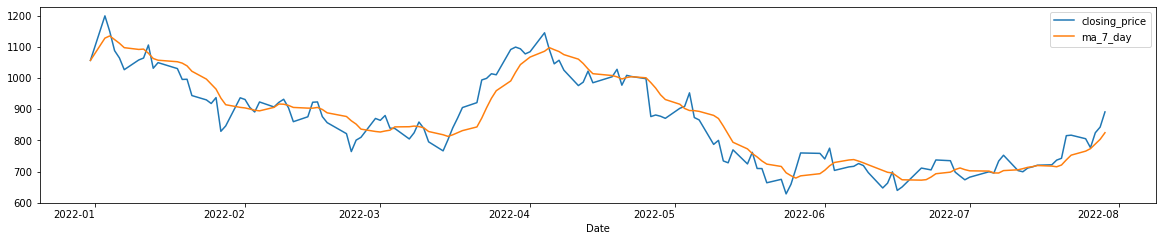

In [11]:
ex2_pandas.query('ticker == "tsla"').set_index('Date')[['closing_price','ma_7_day']].plot(figsize = [20,4],rot = 0)

In [12]:
ex3_sql_query = """
SELECT
    date(Date) AS Date
    , ticker
    , closing_price
    , LEAD(closing_price, 1) OVER(
        PARTITION BY ticker
        ORDER BY date(Date)
    )
      AS next_close
    , LAG(closing_price, 1) OVER(
        PARTITION BY ticker
        ORDER BY date(Date)
    ) AS previous_close
FROM
    prices
"""

In [13]:
ex3_sql = pd.read_sql(ex3_sql_query, con=conn)
ex3_sql

,Date,ticker,closing_price,next_close,previous_close
0,2021-12-31,addyy,141.175522,144.263733,NaN
1,2022-01-03,addyy,144.263733,143.185318,141.175522
2,2022-01-04,addyy,143.185318,142.440216,144.263733
3,2022-01-05,addyy,142.440216,140.126511,143.185318
4,2022-01-06,addyy,140.126511,138.067703,142.440216
...,...,...,...,...,...
720,2022-07-25,tsla,805.299988,776.580017,816.729980
721,2022-07-26,tsla,776.580017,824.460022,805.299988
722,2022-07-27,tsla,824.460022,842.700012,776.580017
723,2022-07-28,tsla,842.700012,891.450012,824.460022


In [14]:
ex3_pandas = prices.sort_values(["ticker","Date"]).copy()

ex3_pandas["next_close"] = (
    ex3_pandas.sort_values(["ticker","Date"]).groupby("ticker")["closing_price"].shift(-1)
)
ex3_pandas["previous_close"] = (
    ex3_pandas.sort_values(["ticker","Date"]).groupby("ticker")["closing_price"].shift(1)
)

ex3_pandas

,Date,ticker,closing_price,next_close,previous_close
580,2021-12-31,addyy,141.175522,144.263733,NaN
581,2022-01-03,addyy,144.263733,143.185318,141.175522
582,2022-01-04,addyy,143.185318,142.440216,144.263733
583,2022-01-05,addyy,142.440216,140.126511,143.185318
584,2022-01-06,addyy,140.126511,138.067703,142.440216
...,...,...,...,...,...
140,2022-07-25,tsla,805.299988,776.580017,816.729980
141,2022-07-26,tsla,776.580017,824.460022,805.299988
142,2022-07-27,tsla,824.460022,842.700012,776.580017
143,2022-07-28,tsla,842.700012,891.450012,824.460022


In [15]:
ex4_sql_query = """
SELECT
    Date
    , ticker
    , closing_price
    , closing_price/previous_close - 1 AS daily_return
FROM
    (
    SELECT
         date(Date) AS Date
        , ticker
        , closing_price
        , LAG(closing_price,1) OVER(
            PARTITION BY ticker ORDER BY date(Date)
        ) AS previous_close
    FROM
        prices
)
"""

In [16]:
ex4_sql = pd.read_sql(ex4_sql_query, con=conn)
ex4_sql


,Date,ticker,closing_price,daily_return
0,2021-12-31,addyy,141.175522,NaN
1,2022-01-03,addyy,144.263733,0.021875
2,2022-01-04,addyy,143.185318,-0.007475
3,2022-01-05,addyy,142.440216,-0.005204
4,2022-01-06,addyy,140.126511,-0.016243
...,...,...,...,...
720,2022-07-25,tsla,805.299988,-0.013995
721,2022-07-26,tsla,776.580017,-0.035664
722,2022-07-27,tsla,824.460022,0.061655
723,2022-07-28,tsla,842.700012,0.022124


In [17]:
ex4_pandas = prices.sort_values(["ticker","Date"]).copy()

ex4_pandas["daily_return_version1"] = (
    ex4_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x / x.shift(1) - 1)
)
ex4_pandas["daily_return_version2"] = (
    ex4_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .pct_change()
)

ex4_pandas

,Date,ticker,closing_price,daily_return_version1,daily_return_version2
580,2021-12-31,addyy,141.175522,NaN,NaN
581,2022-01-03,addyy,144.263733,0.021875,0.021875
582,2022-01-04,addyy,143.185318,-0.007475,-0.007475
583,2022-01-05,addyy,142.440216,-0.005204,-0.005204
584,2022-01-06,addyy,140.126511,-0.016243,-0.016243
...,...,...,...,...,...
140,2022-07-25,tsla,805.299988,-0.013995,-0.013995
141,2022-07-26,tsla,776.580017,-0.035664,-0.035664
142,2022-07-27,tsla,824.460022,0.061655,0.061655
143,2022-07-28,tsla,842.700012,0.022124,0.022124


In [18]:
# copy orginal dataframe
ex5_pandas = prices.sort_values(["ticker","Date"]).copy()

# remove 30% of data randomly
pct_missing = 0.3
num_missing = int(pct_missing * len(ex5_pandas))
np.random.seed(123)
indexes = np.random.randint(0,len(ex5_pandas),num_missing)
# import numpy as np
ex5_pandas.loc[indexes,'closing_price'] = np.nan

In [19]:
# interpolate missing data paritioned by ticker
ex5_pandas["closing_price_interpolated"] = (
    ex5_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .transform(lambda x: x.interpolate(method="polynomial",order = 2))
)

ex5_pandas

,Date,ticker,closing_price,closing_price_interpolated
580,2021-12-31,addyy,141.175522,141.175522
581,2022-01-03,addyy,144.263733,144.263733
582,2022-01-04,addyy,NaN,144.263821
583,2022-01-05,addyy,142.440216,142.440216
584,2022-01-06,addyy,140.126511,140.126511
...,...,...,...,...
140,2022-07-25,tsla,NaN,849.614809
141,2022-07-26,tsla,NaN,827.289432
142,2022-07-27,tsla,824.460022,824.460022
143,2022-07-28,tsla,842.700012,842.700012


<AxesSubplot:title={'center':'Missing imputation\nRED dots'}, xlabel='Date'>

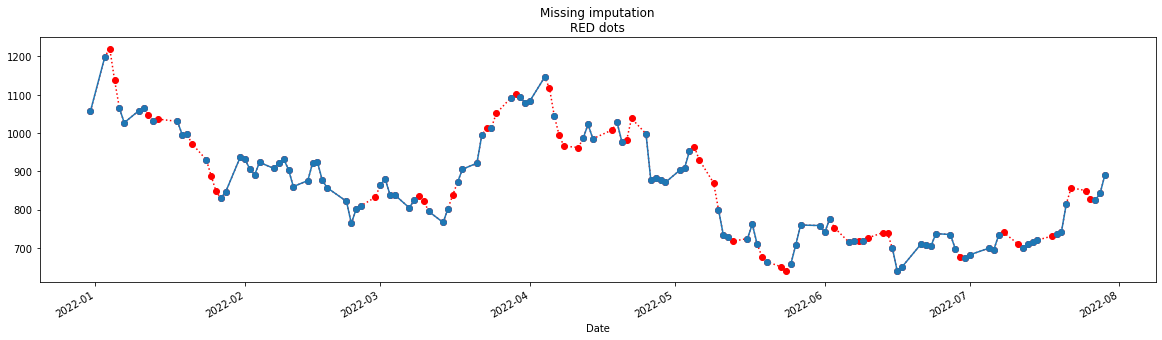

In [20]:
ex5_pandas.query('ticker == "tsla"').set_index('Date')['closing_price_interpolated'].plot(color='red', marker='o', linestyle='dotted', figsize=(20, 5))
ex5_pandas.query('ticker == "tsla"').set_index('Date')['closing_price'].plot(title='Missing imputation\nRED dots', marker='o', figsize=(20, 5))

In [21]:
ex6_sql_query = """
SELECT
     date(Date) AS Date
    , ticker
    , closing_price
    , SUM(closing_price) OVER(
        PARTITION BY ticker ORDER BY date(Date)
    ) AS previous_close
FROM
    prices
"""

In [22]:
ex6_sql = pd.read_sql(ex6_sql_query, con=conn)
ex6_sql

,Date,ticker,closing_price,previous_close
0,2021-12-31,addyy,141.175522,141.175522
1,2022-01-03,addyy,144.263733,285.439255
2,2022-01-04,addyy,143.185318,428.624573
3,2022-01-05,addyy,142.440216,571.064789
4,2022-01-06,addyy,140.126511,711.191299
...,...,...,...,...
720,2022-07-25,tsla,805.299988,121508.629700
721,2022-07-26,tsla,776.580017,122285.209717
722,2022-07-27,tsla,824.460022,123109.669739
723,2022-07-28,tsla,842.700012,123952.369751


In [23]:
ex6_pandas = prices.sort_values(["ticker","Date"]).copy()

ex6_pandas["expanding_sum"] = (
    ex6_pandas.sort_values("Date")
    .groupby("ticker")["closing_price"]
    .expanding(1).sum().values
)
ex6_pandas

,Date,ticker,closing_price,expanding_sum
580,2021-12-31,addyy,141.175522,141.175522
581,2022-01-03,addyy,144.263733,285.439255
582,2022-01-04,addyy,143.185318,428.624573
583,2022-01-05,addyy,142.440216,571.064789
584,2022-01-06,addyy,140.126511,711.191299
...,...,...,...,...
140,2022-07-25,tsla,805.299988,121508.629700
141,2022-07-26,tsla,776.580017,122285.209717
142,2022-07-27,tsla,824.460022,123109.669739
143,2022-07-28,tsla,842.700012,123952.369751


In [24]:
import pandas as pd
import numpy as np

In [25]:
prices

,Date,ticker,closing_price
0,2021-12-31,tsla,1056.780029
1,2022-01-03,tsla,1199.780029
2,2022-01-04,tsla,1149.589966
3,2022-01-05,tsla,1088.119995
4,2022-01-06,tsla,1064.699951
...,...,...,...
720,2022-07-25,addyy,90.019997
721,2022-07-26,addyy,83.650002
722,2022-07-27,addyy,83.330002
723,2022-07-28,addyy,85.300003


### rolling

In [26]:
s = pd.Series(range(5))
for window in s.rolling(window=3):
    print(window)

0    0
dtype: int64
0    0
1    1
dtype: int64
0    0
1    1
2    2
dtype: int64
1    1
2    2
3    3
dtype: int64
2    2
3    3
4    4
dtype: int64


In [27]:
s.rolling(window=3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
dtype: float64

In [28]:
tsla_price = prices.query('ticker == "tsla"')

In [29]:
tsla_price

,Date,ticker,closing_price
0,2021-12-31,tsla,1056.780029
1,2022-01-03,tsla,1199.780029
2,2022-01-04,tsla,1149.589966
3,2022-01-05,tsla,1088.119995
4,2022-01-06,tsla,1064.699951
...,...,...,...
140,2022-07-25,tsla,805.299988
141,2022-07-26,tsla,776.580017
142,2022-07-27,tsla,824.460022
143,2022-07-28,tsla,842.700012


In [30]:
tsla_price['closing_price'].rolling(7).mean().dropna().transform(lambda x: "{0:.02f}".format(x))

6      1092.01
7      1093.10
8      1079.73
9      1062.87
10     1057.37
        ...   
140     765.44
141     773.49
142     788.18
143     803.34
144     824.62
Name: closing_price, Length: 139, dtype: object

### expanding

In [31]:
tsla_price['closing_price'].expanding(7).mean().dropna().transform(lambda x: "{0:.02f}".format(x))

6      1092.01
7      1088.56
8      1090.52
9      1084.62
10     1081.44
        ...   
140     861.76
141     861.16
142     860.91
143     860.78
144     860.99
Name: closing_price, Length: 139, dtype: object

### pct_change

In [32]:
tsla_price['closing_price'].pct_change()

0           NaN
1      0.135317
2     -0.041833
3     -0.053471
4     -0.021523
         ...   
140   -0.013995
141   -0.035664
142    0.061655
143    0.022124
144    0.057850
Name: closing_price, Length: 145, dtype: float64

### ewm


> An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly.

- com ：  float，可选

根据质心指定衰减， α=1/(1+com), for com≥0。

- span ：  float，可选

根据范围指定衰减， α=2/(span+1), for span≥1。

- halflife ：  float，可选

根据半衰期指定衰减， α=1−exp(log(0.5)/halflife),forhalflife>0。

- alpha ：  float，可选

直接指定平滑系数α， 0<α≤1

In [33]:
tsla_price['closing_price'].ewm(span = 4).mean()

0      1056.780029
1      1146.155029
2      1147.907548
3      1120.431650
4      1096.259331
          ...     
140     793.673755
141     786.836260
142     801.885765
143     818.211464
144     847.506883
Name: closing_price, Length: 145, dtype: float64